# Loan default prediction using logistic regression

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Load data

In [2]:
# Variable type is pandas.DataFrame; the useless ID column is excluded. 
loan_data_frame = pd.read_csv('data.csv', usecols=lambda x: x != 'loanID')

### Count of rows

In [3]:
len(loan_data_frame)

50000

### Example of training data

In [4]:
pd.set_option('display.max_columns', None)
loan_data_frame.head(5)

,amount,term,rate,payment,grade,employment,length,home,income,verified,status,reason,state,debtIncRat,delinq2yr,inq6mth,openAcc,pubRec,revolRatio,totalAcc,totalPaid,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalLim,totalRevBal,totalBcLim,totalIlLim
0,8000.0,36 months,0.14,272.07,C,Warehouseman,3 years,RENT,49966.0,Source Verified,Charged Off,credit_card,CA,30.05,0.0,0.0,11.0,0.0,0.55,15.0,5914.67000,48054.0,8100.0,8.0,4369.0,43.0,95.7,60629.0,48054.0,1000.0,52529.0
1,11000.0,36 months,0.10,354.89,B,Vice President,10+ years,MORTGAGE,50000.0,Not Verified,Fully Paid,debt_consolidation,PA,8.74,0.0,2.0,12.0,0.0,0.36,15.0,12024.75000,265838.0,33400.0,4.0,22153.0,19756.0,37.5,297500.0,11844.0,31600.0,0.0
2,35000.0,36 months,0.15,1220.33,D,Owner/Attorney,10+ years,RENT,360000.0,Verified,Current,debt_consolidation,CA,14.50,0.0,1.0,8.0,0.0,0.83,14.0,31668.65000,850150.0,83000.0,2.0,121450.0,7686.0,83.2,907300.0,173260.0,83000.0,100000.0
3,20000.0,60 months,0.12,447.83,C,Analyst,2 years,MORTGAGE,60000.0,Source Verified,Fully Paid,debt_consolidation,CA,14.14,0.0,0.0,12.0,3.0,0.01,48.0,23827.22901,20671.0,14200.0,8.0,1723.0,11061.0,1.2,46964.0,20671.0,11200.0,32764.0
4,12000.0,60 months,0.12,266.88,B,medical technician,10+ years,MORTGAGE,64000.0,Source Verified,Current,debt_consolidation,NJ,5.14,0.0,0.0,8.0,0.0,0.58,22.0,9599.69000,128034.0,14600.0,3.0,18291.0,5904.0,58.4,134600.0,8475.0,14200.0,0.0


### Columns and their description
amount - loan amount  
rate - loan interest rate  
employment - job title of an applicant  
status - loan status

etc., most of them are self-explanatory

## Visualize data

Text(0.5, 1.0, 'Status distribution')

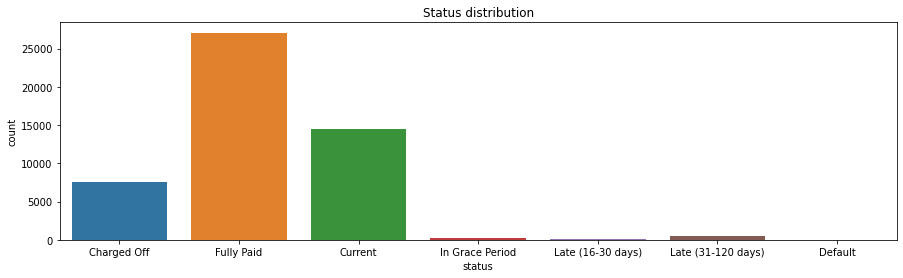

In [5]:
plt.figure(figsize=(15,4))
sns.countplot(x='status',data=loan_data_frame).set_title('Status distribution')

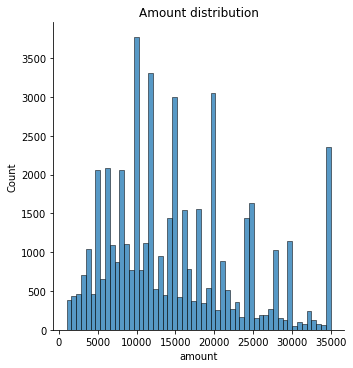

In [6]:
sns.displot(x='amount',data=loan_data_frame).set(title='Amount distribution')

### Empty values

In [7]:
loan_data_frame.isna().sum()

amount            1
term              1
rate              1
payment           1
grade             1
employment     2785
length         2681
home              1
income            1
verified          1
status            1
reason            1
state             1
debtIncRat        1
delinq2yr         1
inq6mth           1
openAcc           1
pubRec            1
revolRatio       19
totalAcc          1
totalPaid         1
totalBal          1
totalRevLim       1
accOpen24         1
avgBal            1
bcOpen          489
bcRatio         521
totalLim          1
totalRevBal       1
totalBcLim        1
totalIlLim        1
dtype: int64

<AxesSubplot:>

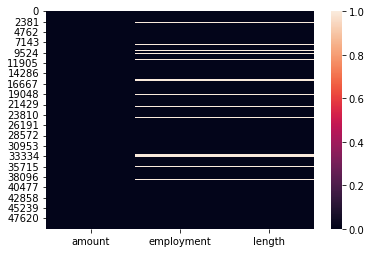

In [8]:
sns.heatmap(loan_data_frame[['amount','employment','length']].isna())

## Prepare data for the model

### Fill empty values

#### Amount

In [9]:
mean_amount = loan_data_frame['amount'].mean()
loan_data_frame['amount'].fillna(mean_amount,inplace=True)
mean_amount

15145.52791055821

#### The rest of columns

In [10]:
# Categorical data
for key in ['employment','length']:
    loan_data_frame[key].fillna(loan_data_frame[key].mode()[0],inplace=True)

# Numerical data
for key in ['bcOpen','bcRatio','revolRatio']:
    loan_data_frame[key].fillna(round(loan_data_frame[key].mean(), 2), inplace=True)

# Drop that one row with almost no data
loan_data_frame = loan_data_frame[loan_data_frame['rate'].notna()]

#### Make sure there are no more NAs

In [11]:
loan_data_frame.isna().sum()

amount         0
term           0
rate           0
payment        0
grade          0
employment     0
length         0
home           0
income         0
verified       0
status         0
reason         0
state          0
debtIncRat     0
delinq2yr      0
inq6mth        0
openAcc        0
pubRec         0
revolRatio     0
totalAcc       0
totalPaid      0
totalBal       0
totalRevLim    0
accOpen24      0
avgBal         0
bcOpen         0
bcRatio        0
totalLim       0
totalRevBal    0
totalBcLim     0
totalIlLim     0
dtype: int64

### Data types before

In [12]:
loan_data_frame.dtypes

amount         float64
term            object
rate           float64
payment        float64
grade           object
employment      object
length          object
home            object
income         float64
verified        object
status          object
reason          object
state           object
debtIncRat     float64
delinq2yr      float64
inq6mth        float64
openAcc        float64
pubRec         float64
revolRatio     float64
totalAcc       float64
totalPaid      float64
totalBal       float64
totalRevLim    float64
accOpen24      float64
avgBal         float64
bcOpen         float64
bcRatio        float64
totalLim       float64
totalRevBal    float64
totalBcLim     float64
totalIlLim     float64
dtype: object

### Convert non-numerical values

In [13]:
for key in ['employment','grade','home','length','reason','state','term','verified']:
    loan_data_frame[key] = loan_data_frame[key].astype('category').cat.codes

### Make dependent value binary

In [14]:
loan_data_frame['status'] = list(map(lambda s: s == 'Fully Paid', loan_data_frame['status']))

### Data types after

In [15]:
loan_data_frame.dtypes

amount         float64
term              int8
rate           float64
payment        float64
grade             int8
employment       int16
length            int8
home              int8
income         float64
verified          int8
status            bool
reason            int8
state             int8
debtIncRat     float64
delinq2yr      float64
inq6mth        float64
openAcc        float64
pubRec         float64
revolRatio     float64
totalAcc       float64
totalPaid      float64
totalBal       float64
totalRevLim    float64
accOpen24      float64
avgBal         float64
bcOpen         float64
bcRatio        float64
totalLim       float64
totalRevBal    float64
totalBcLim     float64
totalIlLim     float64
dtype: object

### Separate dependant and independent variables

In [16]:
x = loan_data_frame.drop(['status'], axis=1)
x

,amount,term,rate,payment,grade,employment,length,home,income,verified,reason,state,debtIncRat,delinq2yr,inq6mth,openAcc,pubRec,revolRatio,totalAcc,totalPaid,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalLim,totalRevBal,totalBcLim,totalIlLim
0,8000.0,0,0.14,272.07,2,17809,3,2,49966.0,1,1,4,30.05,0.0,0.0,11.0,0.0,0.55,15.0,5914.67000,48054.0,8100.0,8.0,4369.0,43.0,95.7,60629.0,48054.0,1000.0,52529.0
1,11000.0,0,0.10,354.89,1,17593,1,0,50000.0,0,2,36,8.74,0.0,2.0,12.0,0.0,0.36,15.0,12024.75000,265838.0,33400.0,4.0,22153.0,19756.0,37.5,297500.0,11844.0,31600.0,0.0
2,35000.0,0,0.15,1220.33,3,11045,1,2,360000.0,2,2,4,14.50,0.0,1.0,8.0,0.0,0.83,14.0,31668.65000,850150.0,83000.0,2.0,121450.0,7686.0,83.2,907300.0,173260.0,83000.0,100000.0
3,20000.0,1,0.12,447.83,2,798,2,0,60000.0,1,2,4,14.14,0.0,0.0,12.0,3.0,0.01,48.0,23827.22901,20671.0,14200.0,8.0,1723.0,11061.0,1.2,46964.0,20671.0,11200.0,32764.0
4,12000.0,1,0.12,266.88,1,19823,1,0,64000.0,1,2,29,5.14,0.0,0.0,8.0,0.0,0.58,22.0,9599.69000,128034.0,14600.0,3.0,18291.0,5904.0,58.4,134600.0,8475.0,14200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,13000.0,1,0.13,298.00,2,2342,1,1,65000.0,2,2,9,27.53,0.0,0.0,16.0,2.0,0.21,33.0,13529.51000,55174.0,28800.0,12.0,3678.0,15385.0,26.0,94757.0,55174.0,20800.0,65957.0
49996,26050.0,1,0.22,719.33,5,16625,1,0,56677.0,0,2,31,20.30,1.0,1.0,14.0,0.0,0.63,28.0,29454.19000,257712.0,34300.0,10.0,19824.0,1541.0,88.3,282755.0,34757.0,13200.0,21215.0
49997,30000.0,1,0.10,637.27,1,11007,6,0,75000.0,0,2,4,14.02,0.0,1.0,11.0,0.0,0.09,21.0,10138.30000,215131.0,89000.0,3.0,19557.0,38077.0,14.4,326428.0,24032.0,44500.0,34946.0
49998,7500.0,0,0.09,239.10,1,1233,1,0,52000.0,0,5,33,30.23,1.0,0.0,18.0,1.0,0.50,40.0,7764.93000,79454.0,26400.0,5.0,4674.0,5105.0,66.6,133481.0,23206.0,15300.0,47659.0


In [17]:
y = loan_data_frame['status']
y

0        False
1         True
2        False
3         True
4        False
         ...  
49995     True
49996     True
49997    False
49998     True
49999     True
Name: status, Length: 49999, dtype: bool

## Build the model

### Split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

### Fit

In [25]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

### Predict

In [26]:
predict = logistic_regression.predict(x_test)
predict

array([ True, False, False, ..., False,  True,  True])

## Test the model

### Confusion matrix

In [27]:
pd.DataFrame(confusion_matrix(y_test,predict))

,0,1
0,4746,977
1,270,6507


### Classification report

In [28]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

       False       0.95      0.83      0.88      5723
        True       0.87      0.96      0.91      6777

    accuracy                           0.90     12500
   macro avg       0.91      0.89      0.90     12500
weighted avg       0.90      0.90      0.90     12500

